Explain ResNet50 using the Partition explainer

In [1]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap

C:\Users\user\anaconda3\envs\shap\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\anaconda3\envs\shap\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\user\anaconda3\envs\shap\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [5]:
# load pre-trained model and data
model = ResNet50(weights='imagenet')
X, y = shap.datasets.imagenet50()

In [6]:
# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
#print("Number of ImageNet classes:", len(class_names))
#print("Class names:", class_names)

In [7]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

  0%|          | 0/48 [00:00<?, ?it/s]

Partition explainer:  50%|███████████████████████████████████▌                                   | 1/2 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Partition explainer: 3it [00:22, 11.32s/it]                                                                            


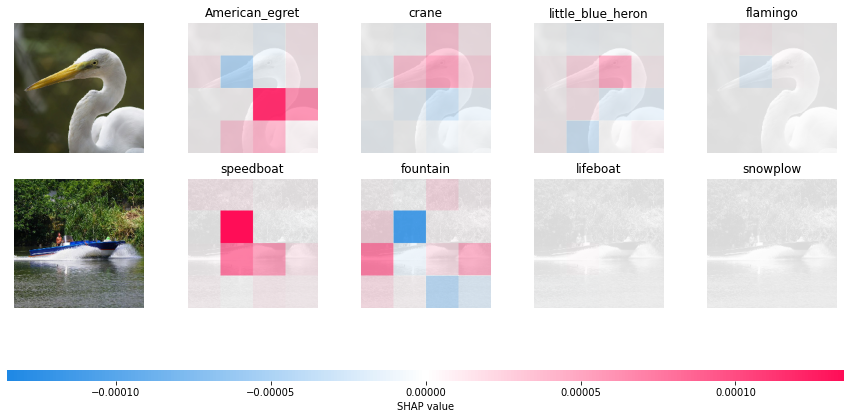

In [8]:
# output with shap values
shap.image_plot(shap_values)

In [9]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(f, masker_blur, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(X[1:3], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

  0%|          | 0/2498 [00:00<?, ?it/s]

Partition explainer:  50%|███████████████████████████████████▌                                   | 1/2 [00:00<?, ?it/s]

  0%|          | 0/2498 [00:00<?, ?it/s]

Partition explainer: 3it [06:16, 188.03s/it]                                                                           


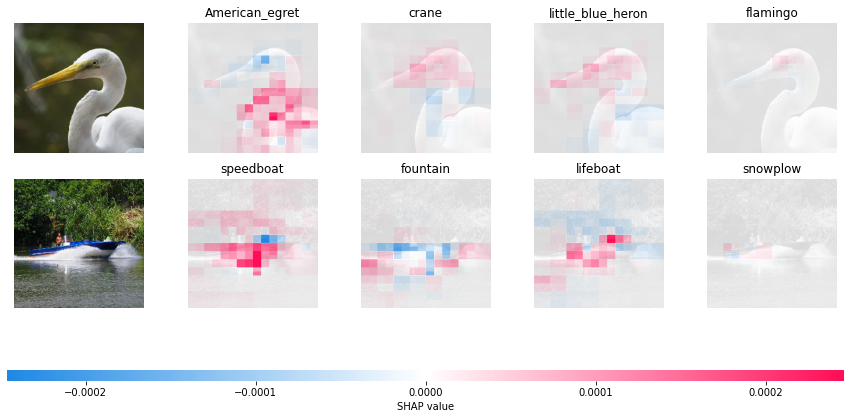

In [10]:
# output with shap values
shap.image_plot(shap_values_fine)

Explain an Intermediate Layer of VGG16 on ImageNet

In [14]:
import torch, torchvision
from torch import nn
from torchvision import transforms, models, datasets
import shap
import json
import numpy as np

In [15]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\user/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

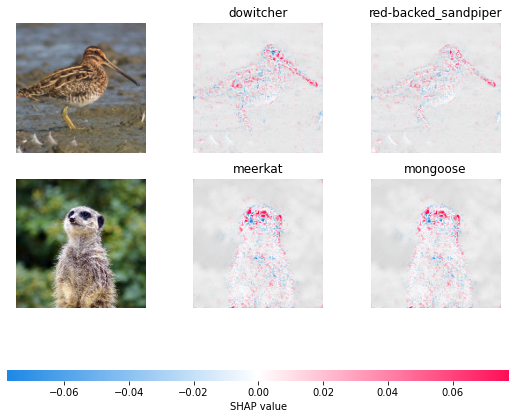

In [16]:
# load the model
model = models.vgg16(pretrained=True).eval()

X,y = shap.datasets.imagenet50()

X /= 255

to_explain = X[[39, 41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

e = shap.GradientExplainer((model, model.features[7]), normalize(X))
shap_values,indexes = e.shap_values(normalize(to_explain), ranked_outputs=2, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

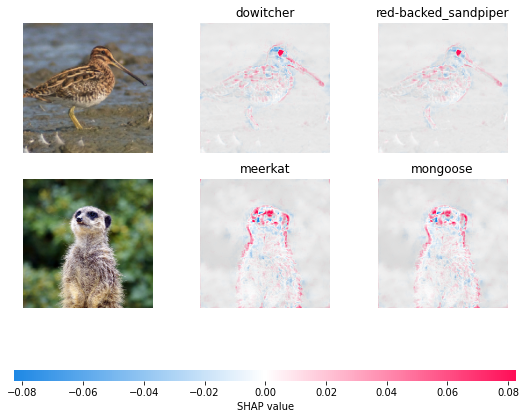

In [17]:
# note that because the inputs are scaled to be between 0 and 1, the local smoothing also has to be
# scaled compared to the Keras model
explainer = shap.GradientExplainer((model, model.features[7]), normalize(X), local_smoothing=0.5)
shap_values,indexes = explainer.shap_values(normalize(to_explain), ranked_outputs=2, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)